In [10]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

   Age        BMI  Glucose  Insulin      HOMA   Leptin  Adiponectin  Resistin  \
0   48  23.500000       70    2.707  0.467409   8.8071     9.702400   7.99585   
1   83  20.690495       92    3.115  0.706897   8.8438     5.429285   4.06405   
2   82  23.124670       91    4.498  1.009651  17.9393    22.432040   9.27715   
3   68  21.367521       77    3.226  0.612725   9.8827     7.169560  12.76600   
4   86  21.111111       92    3.549  0.805386   6.6994     4.819240  10.57635   

     MCP.1  Classification  
0  417.114               1  
1  468.786               1  
2  554.697               1  
3  928.220               1  
4  773.920               1  
              Age         BMI     Glucose     Insulin        HOMA      Leptin  \
count  116.000000  116.000000  116.000000  116.000000  116.000000  116.000000   
mean    57.301724   27.582111   97.793103   10.012086    2.694988   26.615080   
std     16.112766    5.020136   22.525162   10.067768    3.642043   19.183294   
min     24.0000

array([[<Axes: title={'center': 'Age'}>, <Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'Glucose'}>],
       [<Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'HOMA'}>,
        <Axes: title={'center': 'Leptin'}>],
       [<Axes: title={'center': 'Adiponectin'}>,
        <Axes: title={'center': 'Resistin'}>,
        <Axes: title={'center': 'MCP.1'}>],
       [<Axes: title={'center': 'Classification'}>, <Axes: >, <Axes: >]],
      dtype=object)

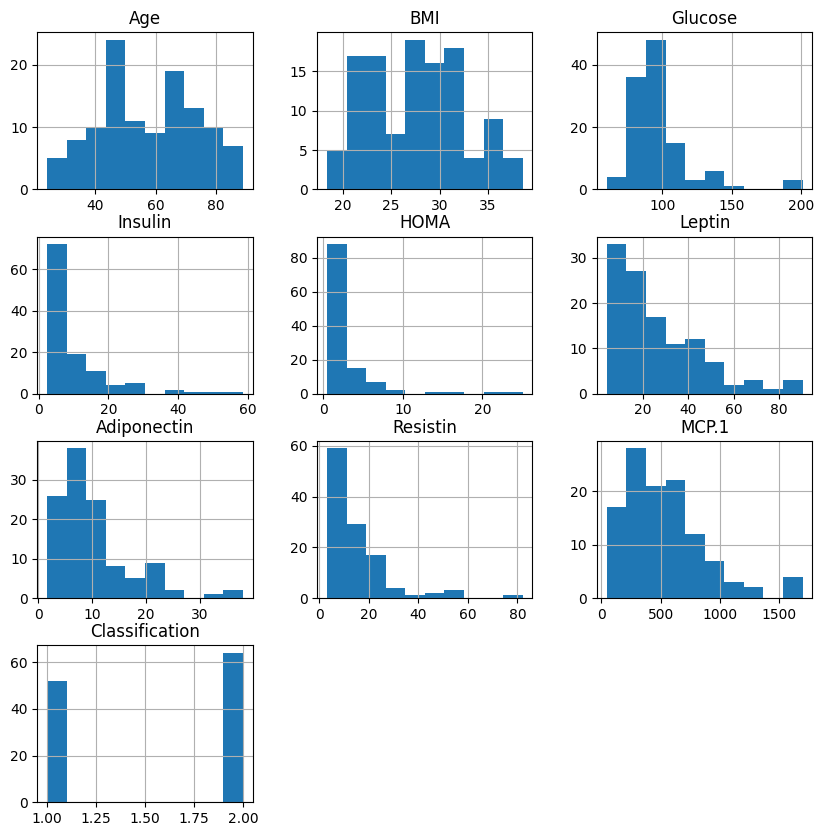

In [2]:
breast_cancer = pd.read_csv("data/breast_cancer.csv")
print(breast_cancer.head())

print(breast_cancer.describe())

print(breast_cancer.info())

print(breast_cancer.isnull().sum())

breast_cancer.hist(figsize=(10, 10))

In [25]:
X = breast_cancer.drop(columns=["Classification"])
y = breast_cancer["Classification"].replace({1: 0, 2: 1})

print(y.value_counts())

Classification
1    64
0    52
Name: count, dtype: int64


In [19]:
print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])
print("Number of classes:", len(np.unique(y)))

Number of samples: 116
Number of features: 9
Number of classes: 2


In [20]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
def build_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=(X.shape[1],)),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 70: early stopping
Restoring model weights from the end of the best epoch: 60.
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 48.
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
Restoring model weights from the end of the best epoch: 100.
Epoch 90: early stopping
Restoring model weights from the end of the best epoch: 80.


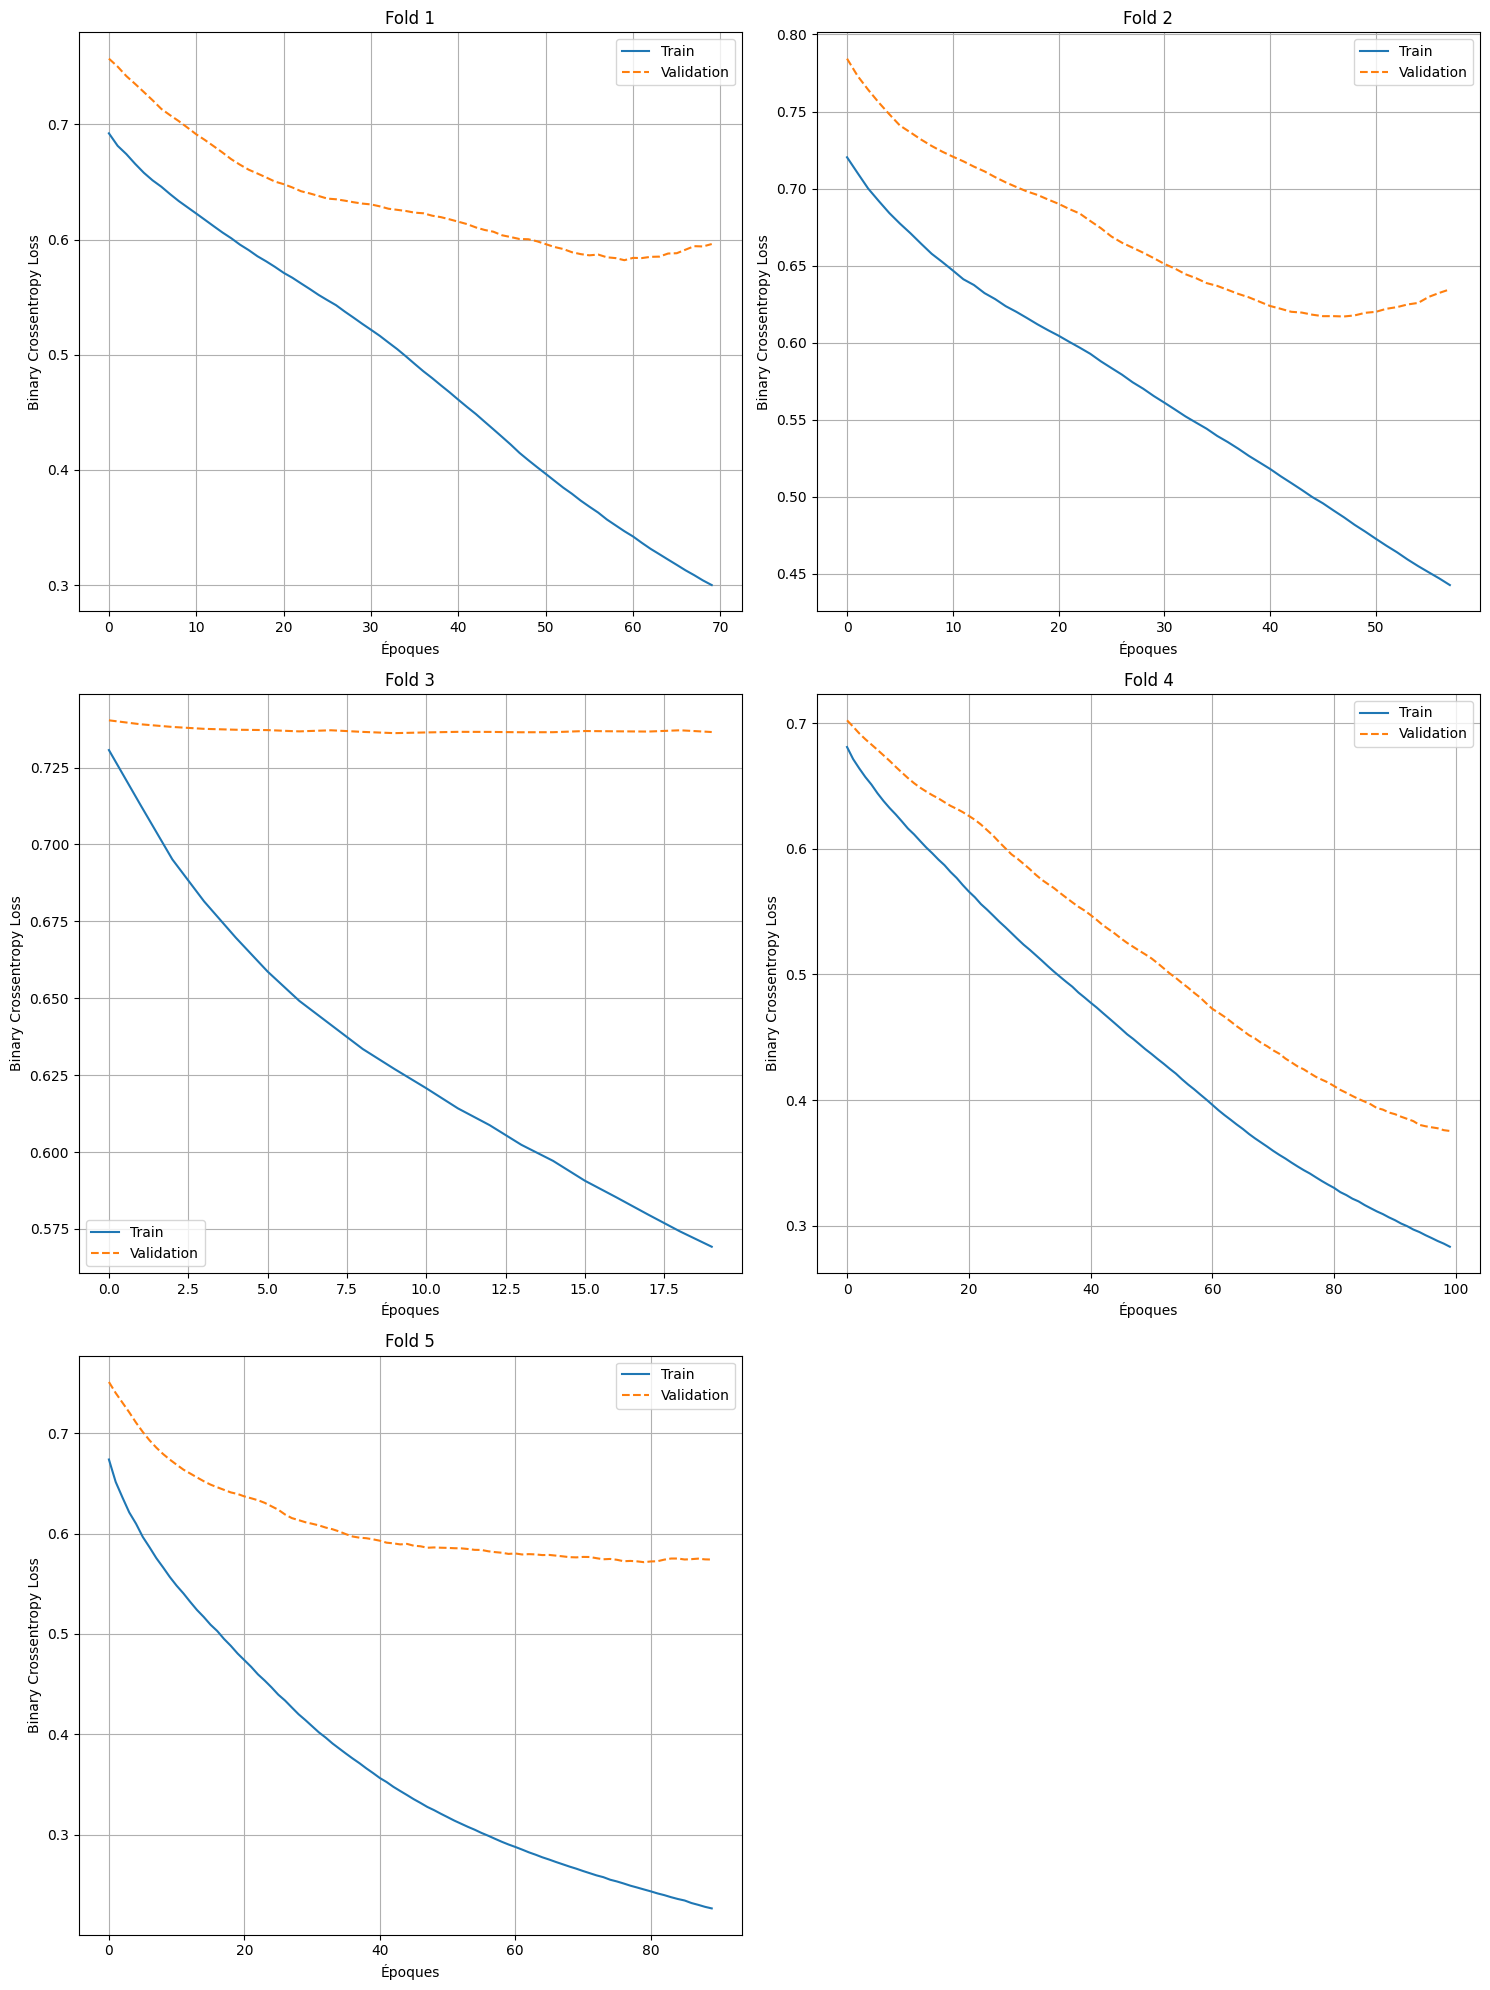

Accuracy moyenne sur validation croisée : 0.7082


In [42]:
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
fold = 1

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axes = axes.ravel()

for train_idx, val_idx in skf.split(X_train_scaled, y_train):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = build_model()
    history = model.fit(X_tr, y_tr,
                        validation_data=(X_val, y_val),
                        epochs=100, batch_size=16, verbose=0, callbacks=[early_stopping])

    acc = model.evaluate(X_val, y_val, verbose=0)[1]
    accuracies.append(acc)

    axes[fold-1].plot(history.history['loss'], label='Train')
    axes[fold-1].plot(history.history['val_loss'], '--', label='Validation')
    axes[fold-1].set_title(f'Fold {fold}')
    axes[fold-1].set_xlabel('Époques')
    axes[fold-1].set_ylabel('Binary Crossentropy Loss')
    axes[fold-1].legend()
    axes[fold-1].grid(True)
    fold += 1

# Hide the last (empty) subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

print(f"Accuracy moyenne sur validation croisée : {np.mean(accuracies):.4f}")

In [43]:
# Évaluation finale sur le jeu de test
final_model = build_model()
final_model.fit(X_train_scaled, y_train, epochs=100, batch_size=16, verbose=0)
test_loss, test_acc = final_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Performance finale sur test : {test_acc:.4f}")

Performance finale sur test : 0.7500


Dans le cadre de la classification binaire à partir du dataset Breast Cancer Coimbra, le respect de la distribution des classes lors de la séparation des données est une condition essentielle à la validité des résultats expérimentaux.

1. Utilisation de stratify=y dans train_test_split
Lors de la séparation du jeu de données en un ensemble d'entraînement et un ensemble de test, nous avons recours à la fonction train_test_split de la bibliothèque scikit-learn. Afin de garantir que les proportions des classes cibles soient conservées dans les deux sous-ensembles, l’argument stratify=y est utilisé.

Cette précaution est particulièrement importante dans le cas de jeux de données déséquilibrés, comme c’est le cas ici, où les deux classes de la variable cible ("Classification") ne sont pas également représentées. Un échantillonnage aléatoire simple pourrait introduire un déséquilibre important entre les classes dans le jeu de test, rendant les métriques de performance peu fiables et favorisant potentiellement une classe au détriment de l’autre. L’option stratify=y assure donc une représentativité statistique des classes dans chacun des sous-échantillons.

2. Recours à StratifiedKFold pour la validation croisée
De manière analogue, lors de l'évaluation du modèle par validation croisée, nous avons choisi l’utilisation de la méthode StratifiedKFold. Contrairement à la validation croisée standard (KFold), cette méthode garantit que la proportion des classes est maintenue dans chacun des k folds.

L’objectif est d’obtenir une estimation plus robuste et plus stable de la performance du modèle, en particulier en présence de déséquilibre entre les classes. Le maintien de la structure du dataset initial dans chaque fold limite le risque de surapprentissage (overfitting) ou de sous-apprentissage sur certains folds dominés par une seule classe.

3. Justification statistique
Le maintien de la distribution des classes dans les procédures d’échantillonnage est une exigence classique en statistique, relevant du principe de représentativité des échantillons. En classification supervisée, l'utilisation systématique de méthodes stratifiées permet d'améliorer la validité externe des résultats (capacité du modèle à généraliser) tout en réduisant la variance des estimations obtenues lors de la validation croisée.